In [1]:
from importlib import reload

import numpy as np
from scipy import signal

import matplotlib.pyplot as plt
%matplotlib inline

import pyfda
print(pyfda.__version__)

0.1.0


This notebook demonstrates how to use the `FilterIIR` object embedded in the `pyfda` package.  The current implementation has numerous limitations - some of those limitations are highlighted (hopefully).

The first step is to create an `FilterIIR` object, the arguments to the constructor are the coefficients of the filter to be constructed and the fixed-point format to be used.  The current fixed-point format used is a *tuple*  that represents the word-length (`iwl`), integer-word-length (`iwl`), and fractional-word-length (`fwl`): `(wl, iwl, fwl)`.

This filter object limits the filter structure to second order type I and type II (type II to be implemented soon).  Larger order filters can be created but second order sections (sos) will be used, an array of the section coefficients need to be pass, this will be reviewed later in this example.

In [2]:
reload(pyfda)
reload(pyfda.hdl_generation.filter_iir)

b, a = signal.butter(2, .1)
print(b, a)
flt = pyfda.hdl_generation.filter_iir.FilterIIR(b=b, 
                                                a=a, 
                                                word_format=(6,0,0))

[ 0.02008337  0.04016673  0.02008337] [ 1.         -1.56101808  0.64135154]


At this point not much has occurred other than creating the object and the filter coefficient quantization according to the fixed-point format passed.  The frequency repsonse of the original coefficients and the quantized coefficients can be generated. 

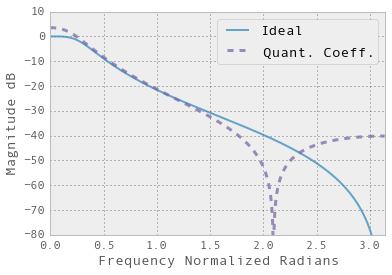

In [3]:
fig, ax = plt.subplots(1)
flt.plot_response(ax)

In this example we can see the error due to the small word-size used, increasing the word size we can see creating quatinzed coefficients has no effect on the magnitude response

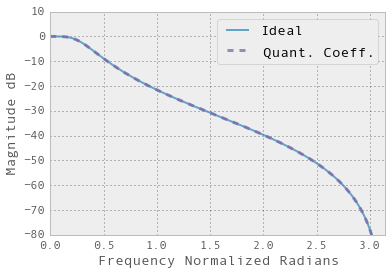

In [4]:
flt = pyfda.hdl_generation.filter_iir.FilterIIR(b=b, a=a, word_format=(24,0,0))
fig, ax = plt.subplots(1)
flt.plot_response(ax)

The above plots only show analytic response of the original floating-point coefficients and the quantized fixed-point coefficients.  The filter HDL can be simulated to test the response of the actual filter implementation.

In [5]:
reload(pyfda)
reload(pyfda.hdl_generation.filter_iir)
reload(pyfda.hdl_generation.filter_iir_hdl)

# create a new filter with 16bit words
flt = pyfda.hdl_generation.filter_iir.FilterIIR(
        b=b, a=a, word_format=(16,0,0))

# simulate the response of the HDL digital filter
%time flt.simulate_freqz(num_loops=5)

CPU times: user 14.5 s, sys: 292 ms, total: 14.8 s
Wall time: 15.6 s


If the plot is run again it will inlcude the information from the simulation.

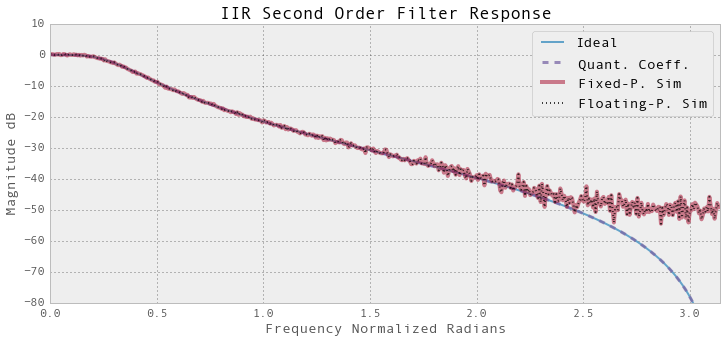

In [6]:
fig, ax = plt.subplots(1, figsize=(12,5))
flt.plot_response(ax)
ax.set_title("IIR Second Order Filter Response")

For custom plots (to match the *pyfda* plot type) the `plot_response` function can be updated or the following attributes can be used:

   - `flt.fxb`: fixed-point numerator coefficients.
   - `flt.fxa`: fixed-point denominator coeffcients.
   - `flt.b` and `flt.a`: saved floating-point coefficients.
   - `flt.xfavg`: FFT averaged frames (size Nfft) of the simulated inputs.
   - `flt.yfavg`: FFT averaged frames (size Nfft) of the simulated outputs.
   - `flt.pfavg`: FFT averaged frames (size Nfft) of the floating-point model outputs (same inputs).
   
The above attributes of the HDL filter (`FilterIIR`) can be used to reconstruct the plots created with `plot_response`.


The code can be converted to Verilog or VHDL.

In [8]:
flt.hdl_name = 'filter_iir'
flt.hdl_directory = 'output'
flt.hdl_target = 'verilog'
flt.convert()

In [9]:
ls output

filter_iir.v                       tb_filter_iir.v
filter_iir_shared_multiplier.v     tb_filter_iir_shared_multiplier.v


In [10]:
%less output/filter_iir.v

In [11]:
!iverilog output/filter_iir.v

The following demonstrates using the above filter but setting the `shared_multiplier` attribute to generate HDL that contains a single multiplier per section.

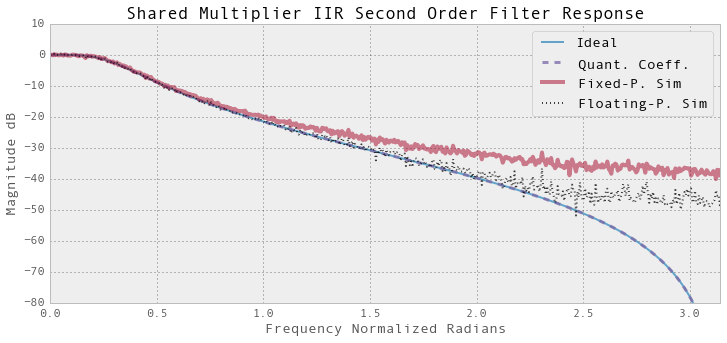

In [12]:
reload(pyfda)
reload(pyfda.hdl_generation.filter_iir)
reload(pyfda.hdl_generation.filter_iir_hdl)

flt = pyfda.hdl_generation.filter_iir.FilterIIR(
        b=b, a=a, word_format=(16,0,0))
flt.shared_multiplier = True
flt.simulate_freqz(num_loops=5)
fig, ax = plt.subplots(1, figsize=(12,5))
flt.plot_response(ax)
ax.set_title("Shared Multiplier IIR Second Order Filter Response")

^^^ currently an issue with the shared multiplier implementation, the frequency responses should be the same!  This needs to be debugged.

In [13]:
flt.hdl_name = 'filter_iir_shared_multiplier'
flt.hdl_directory = 'output'
flt.hdl_target = 'verilog'
flt.convert()

In [14]:
ls output

filter_iir.v                       tb_filter_iir.v
filter_iir_shared_multiplier.v     tb_filter_iir_shared_multiplier.v


In [15]:
%less output/filter_iir_shared_multiplier.v

In [16]:
!iverilog output/filter_iir_shared_multiplier.v